# Tessellations network nodes cleaning

This notebook tests a way to remove nodes that only connect two edges from the network (Nodes that connect two edges should not be intersections, should be continous lines).

* __Result:__ Success! 
* __Only problem:__ In the last step, a MultiLineString may not be able to be converted to a LineString if its path overlaps with itself. (Can happen in Tessellations network since some lines use the same path at the very last time before meeting at their common node)

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# Para obtener el punto central de una línea en los tests,
# Y para convertir MultiLineStrings a LineStrings.
from shapely.geometry import LineString, MultiLineString

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [3]:
# ----- ----- ----- Input ----- ----- -----
input_dir = accesibilidad_urbana + "data/external/volvo/input_tessellations_network/"
# ----- Input nodes
# MORAVIA (Non-functional, simplified network)
# input_nodes_dir = input_dir + "moravia_LH_tessellations_edited_nodes.shp"
# MORAVIA (Functional, non-simplified network)
# input_nodes_dir = input_dir + "moravia_LH_tessellations_nodes_2.shp"
# MEDELLÍN (Functional, non-simplified network)
input_nodes_dir = input_dir + "medellin_tessellations_nodes.shp"
# ----- Input edges
# MORAVIA (Non-functional, simplified network)
# input_edges_dir = input_dir + "moravia_LH_tessellations_edited_edges.shp"
# MORAVIA (Functional, non-simplified network)
# input_edges_dir = input_dir + "moravia_LH_tessellations_edges_2.shp"
# MEDELLÍN (Functional, non-simplified network)
input_edges_dir = input_dir + "medellin_tessellations_edges.shp"

# ----- ----- ----- Projection to be used when needed ----- ----- ----- 
projection_crs = "EPSG:32618"

# ----- ----- ----- Output ----- ----- ----- 
output_dir = accesibilidad_urbana + "data/external/volvo/output_tessellations_network/"
# ----- Output nodes
# MORAVIA
#output_nodes_dir = output_dir + "moravia_LH_tesselations_nodes_f.gpkg"
# MEDELLÍN
output_nodes_dir = output_dir + "medellin_tessellations_nodes_f.gpkg"
# ----- Output edges
# MORAVIA
#output_nodes_dir = output_dir + "moravia_LH_tesselations_edges_f.gpkg"
# MEDELLÍN
output_edges_dir = output_dir + "medellin_tessellations_edges_f.gpkg"

## Load data

In [4]:
tessellations_nodes = gpd.read_file(input_nodes_dir)

# Show
print(tessellations_nodes.shape)
print(tessellations_nodes.crs)
tessellations_nodes.head(2)

(28961, 2)
EPSG:4326


,osmid,geometry
0,0,POINT (-75.63493 6.06985)
1,1,POINT (-75.63426 6.06961)


In [5]:
# No duplicates in osmid check
print(tessellations_nodes.shape)
test = tessellations_nodes.copy()
test.drop_duplicates(subset='osmid',inplace=True)
print(test.shape)

(28961, 2)
(28961, 2)


In [6]:
tessellations_edges = gpd.read_file(input_edges_dir)

# Show
print(tessellations_edges.shape)
print(tessellations_edges.crs)
tessellations_edges.head(2)

(47002, 4)
EPSG:4326


,u,v,key,geometry
0,0,1,0,"LINESTRING (-75.63493 6.06985, -75.63493 6.069..."
1,0,5,0,"LINESTRING (-75.63493 6.06985, -75.63493 6.069..."


In [7]:
# No duplicates in u,v check
print(tessellations_edges.shape)
test = tessellations_edges.copy()
test.drop_duplicates(subset=['u','v','key'],inplace=True)
print(test.shape)

(47002, 4)
(47002, 4)


<Axes: >

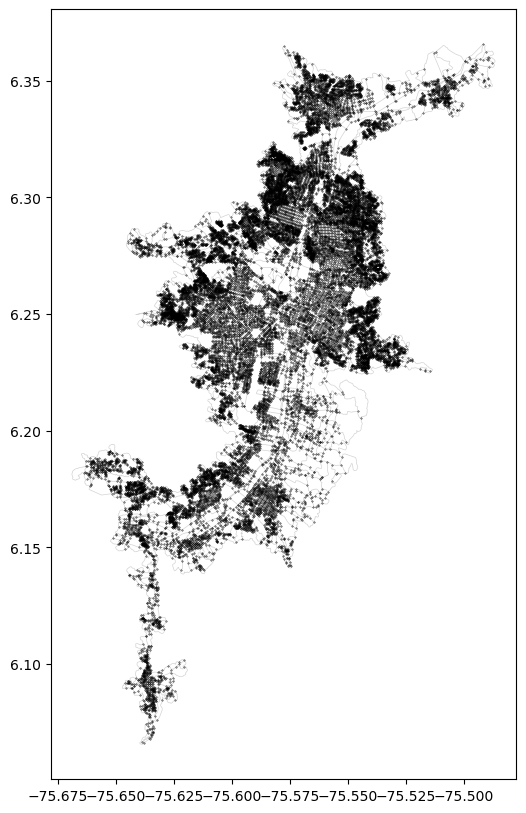

In [8]:
# Show plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
tessellations_nodes.plot(ax=ax,zorder=1,color='black',markersize=.1)
tessellations_edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=.5)

## Developing process

### Developing - Exploring overlapping edges problem [Solved]

Overlapping was due to a previous tessellation simplification.

In [15]:
midpoints = tessellations_edges.copy()

# Find midpoint for each edge
def midpoint_of_linestring(line):
    if isinstance(line, LineString):
        midpoint = line.interpolate(0.5, normalized=True)
        return midpoint
    else:
        return None
midpoints['midpoint'] = midpoints['geometry'].apply(midpoint_of_linestring)
midpoints.drop(columns=['geometry'],inplace=True)
midpoints.rename(columns={'midpoint':'geometry'},inplace=True)
midpoints.set_geometry('geometry',inplace=True)

# Create a buffer around midpoints
midpoints = midpoints.to_crs(projection_crs)
midpoints_buffer = gpd.GeoDataFrame(geometry=midpoints.buffer(1))
midpoints_buffer = midpoints_buffer.to_crs("EPSG:4326")

# Find lines intersecting each buffer
midpoints_buffer = midpoints_buffer.reset_index()
midpoints_buffer.rename(columns={'index':'buffer_id'},inplace=True)
buffer_edges = gpd.sjoin(tessellations_edges,midpoints_buffer)
grouped_by = buffer_edges.groupby(['u','v']).count()

# Find overlapping edges
overlapping = grouped_by.loc[grouped_by.buffer_id>1]
overlapping = overlapping.reset_index()[['u','v']]

overlapping_buffers_ids = list(overlapping.merge(buffer_edges,on=['u','v']).buffer_id.unique())
overlapping_buffers = midpoints_buffer.loc[midpoints_buffer.buffer_id.isin(overlapping_buffers_ids)]

overlapping_buffers

,buffer_id,geometry


In [23]:
test_save = False

# Save to explore in QGIS
if test_save:
    overlapping_buffers.to_file(accesibilidad_urbana + "data/external/volvo/overlapping_2.gpkg")
    # Saved files:
    # Using simplified network --> 'overlapping' (Non-functional network)
    # Using network_2 (unsimplified) --> 'overlapping_2' (Functional network)

### Developing - Identify nodes used only by two edges 
##### (Those are not intersections, they should be a single line)

In [26]:
# ----- PART 1: IDENTIFY NODES THAT ARE USED BY ONLY TWO EDGES
u_list = list(tessellations_edges.u)
v_list = list(tessellations_edges.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(tessellations_nodes.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = tessellations_nodes.osmid == osmid
    tessellations_nodes.loc[idx,'streets_count'] = streets_count

# Osmids that only recieve two edges are not intersections, should be a continous line
two_edge_osmids = tessellations_nodes.loc[tessellations_nodes.streets_count==2].copy()
print(f"Found {len(two_edge_osmids)} nodes with two edges only.")

# ----- PART 2: REMOVE USELESS NODE, DISSOLVE LINES PREVIOUSLY USING THAT NODE.

# LOG CODE - Progress logs
# Will create progress logs when progress reaches these percentages:
progress_logs = [10,20,30,40,50,60,70,80,90,100] # for log statistics
i = 0

fixed_nodes = tessellations_nodes.copy()
fixed_edges = tessellations_edges.copy()
two_edge_osmids_lst = list(two_edge_osmids.osmid.unique())
for redundant_osmid in two_edge_osmids_lst:
    
    #print("--"*10)
    #print(f"OSMID OF INTEREST: {osmid}.")

    # LOG CODE - Progress logs
	# Measures current progress, prints if passed a checkpoint of progress_logs list.
    current_progress = (i / len(two_edge_osmids_lst))*100
    for checkpoint in progress_logs:
        if current_progress >= checkpoint:
            print(f'Merging two-edge-osmids. {checkpoint}% done.')
            progress_logs.remove(checkpoint)
            break
    
    # Find edges that use that redundant_osmid
    found_in_u = fixed_edges.loc[fixed_edges.u == redundant_osmid].copy()
    found_in_v = fixed_edges.loc[fixed_edges.v == redundant_osmid].copy()
    found_edges = pd.concat([found_in_u,found_in_v])
    #print(found_edges)
    
    # Find the other osmids those edges connect with
    u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
    while redundant_osmid in u_v_list:
        u_v_list.remove(redundant_osmid)
    #print(f"OSMIDS TO KEEP: {u_v_list}.")

    # The redundant_osmid could be connecting two parts of a circle. 
    # If this happens, u_v_list will have only one osmid. 
    # Duplicate. The new edge's end will be its beginning.
    if len(u_v_list) == 1:
        u_v_list.append(u_v_list[0])

    # Dissolve lines (Creates MultiLineString)
    flattened_edge = found_edges.dissolve()
    flattened_edge['u'] = u_v_list[0]
    flattened_edge['v'] = u_v_list[1]
    flattened_edge['key'] = 0

    # Delete useless node and previous edges, concat new flattened edge.
    fixed_nodes = fixed_nodes.loc[fixed_nodes.osmid != redundant_osmid].copy()
    fixed_edges = fixed_edges.loc[(fixed_edges.u != redundant_osmid)&(fixed_edges.v != redundant_osmid)].copy()
    fixed_edges = pd.concat([fixed_edges,flattened_edge])

    i+=1

# Final format
fixed_edges.reset_index(inplace=True)
fixed_edges.drop(columns=['index'],inplace=True)

# Final format
fixed_nodes.reset_index(inplace=True)
fixed_nodes.drop(columns=['index'],inplace=True)

# Show
print(fixed_edges.shape)
fixed_edges.tail(5)

Found 129 nodes with two edges only.
Merging two-edge-osmids. 10% done.
Merging two-edge-osmids. 20% done.
Merging two-edge-osmids. 30% done.
Merging two-edge-osmids. 40% done.
Merging two-edge-osmids. 50% done.
Merging two-edge-osmids. 60% done.
Merging two-edge-osmids. 70% done.
Merging two-edge-osmids. 80% done.
Merging two-edge-osmids. 90% done.
(46873, 4)


,u,v,key,geometry
46868,29148,29149,0,"MULTILINESTRING ((-75.54368 6.34719, -75.54368..."
46869,28638,28639,0,"MULTILINESTRING ((-75.53245 6.34580, -75.53245..."
46870,28683,28709,0,"MULTILINESTRING ((-75.51097 6.34219, -75.51096..."
46871,29203,29232,0,"MULTILINESTRING ((-75.49131 6.35049, -75.49131..."
46872,29252,29251,0,"MULTILINESTRING ((-75.49593 6.35454, -75.49593..."


### Developing - Result evaluation

In [28]:
# ----- RE-IDENTIFY NODES THAT ARE USED BY ONLY TWO EDGES
u_list = list(fixed_edges.u)
v_list = list(fixed_edges.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(fixed_nodes.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = fixed_nodes.osmid == osmid
    fixed_nodes.loc[idx,'streets_count'] = streets_count

# Osmids that only recieve two edges are not intersections, should be a continous line
two_edge_osmids = fixed_nodes.loc[fixed_nodes.streets_count==2].copy()
two_edge_osmids

,osmid,geometry,streets_count


### Developing - Convert MultiLineStrings into LineStrings by joining their coordinates

In [31]:
# Test (Plot line that is a MultiLineString)
#multiline_lines = fixed_edges.loc[(fixed_edges.u==513) & (fixed_edges.v==517)] #Codes apply to Moravia.
#multiline_lines.plot()

In [34]:
# Function to check if two lines connect properly, if one needs to be reversed or if both need to be reversed.
def lines_connect(line1, line2):

    # Case 1: Last coord of first line connects with first coord of second line. No modification needed.
    if line1.coords[-1] == line2.coords[0]:
        return True, line1, line2

    # Case 2: First coord of first line connects with first coord of second line. Reverse first line.
    elif line1.coords[0] == line2.coords[0]:
        line1_reversed = LineString(line1.coords[::-1])
        return True, line1_reversed, line2

    # Case 3: Last coord of first line connects with Last coord of second line. Reverse second line.
    elif line1.coords[-1] == line2.coords[-1]:
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1, line2_reversed

    # Case 4: First coord of first line connects with Last coord of second line. Reverse both lines.
    elif line1.coords[0] == line2.coords[-1]:
        line1_reversed = LineString(line1.coords[::-1])
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1_reversed, line2_reversed

    # Case 5: No coords connect
    else:
        return False, line1, line2
        
# Function to convert MultiLineStrings to properly connected LineStrings
def multilinestring_to_linestring(row):
    line = row['geometry']
    
    # If the geometry is already a LineString, return it as is
    if isinstance(line, LineString):
        return row
    
    # If it's a MultiLineString, concatenate all LineStrings' coordinates, ensuring they connect
    elif isinstance(line, MultiLineString):
        
        # Extract and combine all coordinates from each LineString in MultiLineString
        all_coords = list(line.geoms[0].coords)  # Start with the first LineString's coordinates

        # LineStrings to be concatenated to first LineString
        lines_i = []
        for i in range(1,len(line.geoms)):
            lines_i.append(i)
        
        # Added attempts limit for cases where an node is shared by two edges
        # that coincide in various points (very very rare, due to Volvo's Tessellations network)
        attempts = 0
        attempts_limit = 100
        
        # Iterate over the remaining LineStrings and ensure they connect
        while len(lines_i)>0: # While there are still lines to be connected

            if attempts < attempts_limit:
                # Iterate over each one of them and try to find a connection to line formed so far
                for i in lines_i: 

                    # Lines to connect
                    joining_line = LineString(all_coords) # The line formed so far
                    new_line = line.geoms[i] # The new line to be connected
                    # Check if lines connect, and reverse lines if needed for connection
                    connection, joining_line, new_line = lines_connect(joining_line, new_line)
                    # Perform connection
                    if connection:
                        # Register current coords (cannot use previous, might be reversed)
                        all_coords = list(joining_line.coords)
                        # Extend the coordinate list with the new line's coordinates
                        all_coords.extend(list(new_line.coords))
                        # Remove added i from lines_i list
                        lines_i.remove(i)
                    # Add attempt
                    attempts+=1
            else:
                # Stop
                print(f"Edge {row['u']},{row['v']},{row['key']} exceeded the attempts limit for MultiLineString to LineString conversion.")
                global multilinestring_fail_lst
                multilinestring_fail_lst.append(row['u']+row['v']+row['key'])
                return row
        
        # Update the row's geometry with the new LineString
        row['geometry'] = LineString(all_coords)
        return row

# Convert MultiLineStrings to LineStrings
multilinestring_fail_lst = []
flattened_lines = fixed_edges.apply(multilinestring_to_linestring,axis=1)
flattened_lines.tail(5)

Edge 16559,16560,0 exceeded the attempts limit for MultiLineString to LineString conversion.


,u,v,key,geometry
46868,29148,29149,0,"LINESTRING (-75.54397 6.34712, -75.54397 6.347..."
46869,28638,28639,0,"LINESTRING (-75.53241 6.34605, -75.53241 6.346..."
46870,28683,28709,0,"LINESTRING (-75.51097 6.34219, -75.51096 6.342..."
46871,29203,29232,0,"LINESTRING (-75.49131 6.35049, -75.49131 6.350..."
46872,29252,29251,0,"LINESTRING (-75.49593 6.35454, -75.49593 6.354..."


In [35]:
# Test (Concatenated LineString on top of line that was a MultiLineString)
#fig,ax = plt.subplots(figsize=(10,10))

#test_lines = flattened_lines.loc[(flattened_lines.u==513) & (flattened_lines.v==517)]#Codes apply to Moravia.
#test_lines.plot(ax=ax,zorder=1,color='green')
#multiline_lines.plot(ax=ax,zorder=0,color='red')

<Axes: >

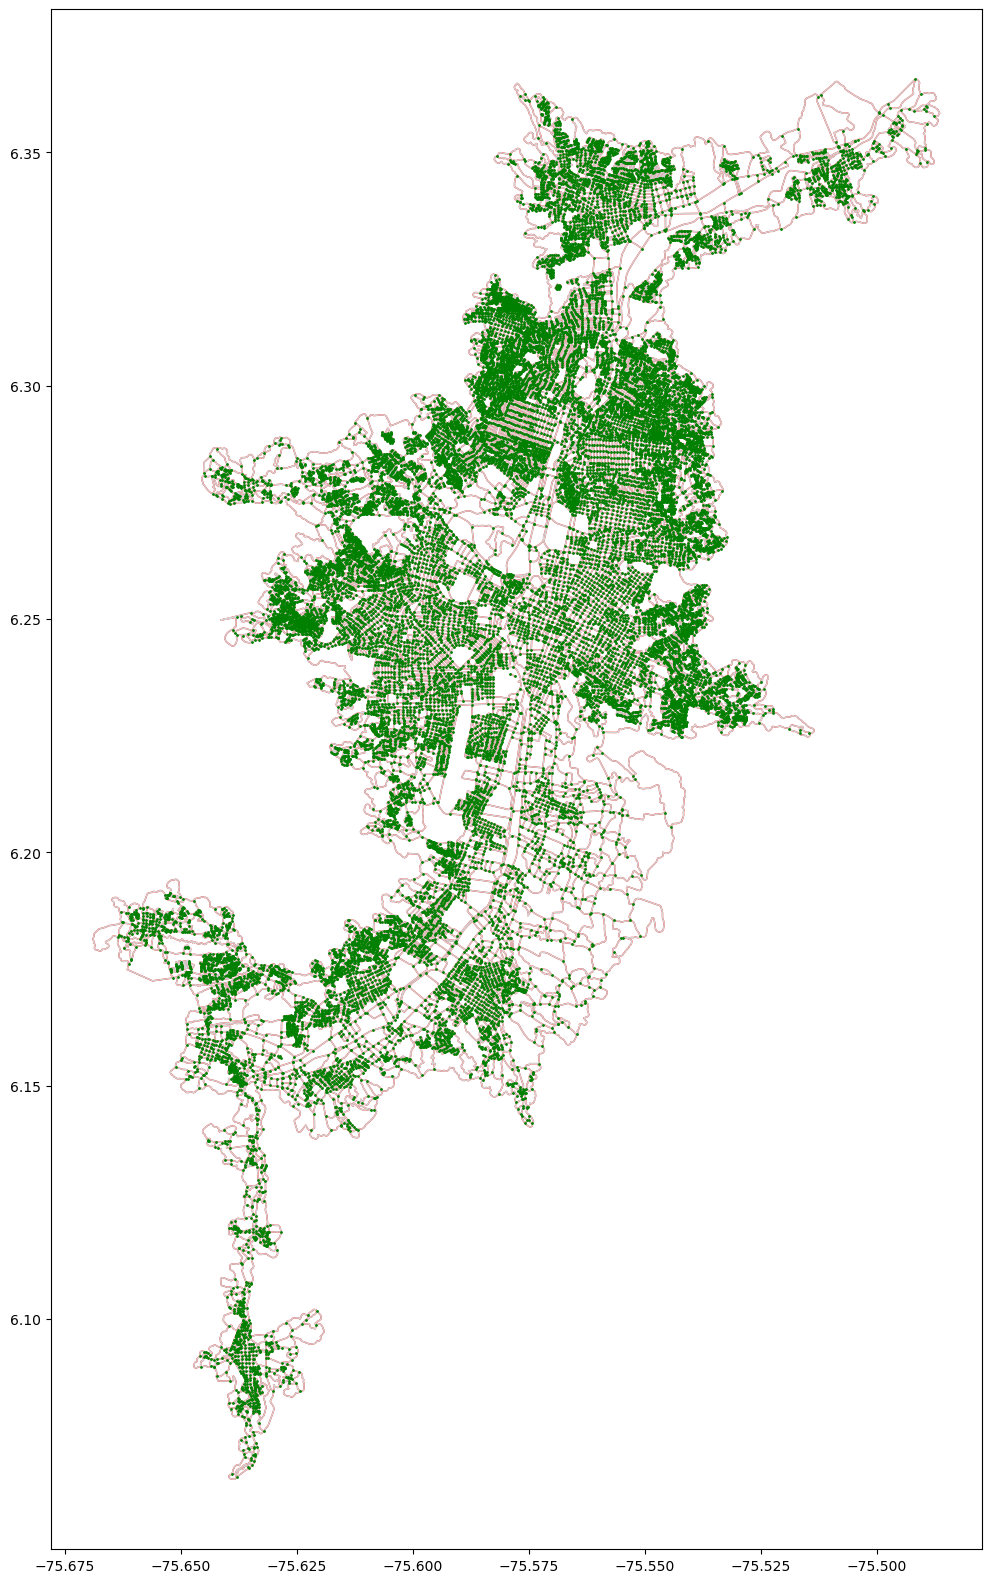

In [36]:
# Show plot
fig,ax = plt.subplots(1,1,figsize=(20,20))
fixed_nodes.plot(ax=ax,zorder=2,color='green',markersize=1)
flattened_lines.plot(ax=ax,zorder=1,color='lightgrey',linewidth=1)
fixed_edges.plot(ax=ax,zorder=0,color='red',linewidth=1)

In [37]:
# Previous output format check
print(fixed_edges.geom_type.unique())
print(fixed_edges.shape)
print(fixed_edges.crs)
fixed_edges.head(1)

['LineString' 'MultiLineString']
(46873, 4)
EPSG:4326


,u,v,key,geometry
0,0,1,0,"LINESTRING (-75.63493 6.06985, -75.63493 6.069..."


In [38]:
# New output format check
print(flattened_lines.geom_type.unique())
print(flattened_lines.shape)
print(flattened_lines.crs)
flattened_lines.head(1)

['LineString' 'MultiLineString']
(46873, 4)
EPSG:4326


,u,v,key,geometry
0,0,1,0,"LINESTRING (-75.63493 6.06985, -75.63493 6.069..."


In [41]:
flattened_lines.loc[flattened_lines.geom_type=='MultiLineString']

,u,v,key,geometry
46836,16559,16560,0,"MULTILINESTRING ((-75.54480 6.25299, -75.54485..."


In [43]:
# Output save
output_save = False

# Save to explore in QGIS
if output_save:
    fixed_nodes.to_file(output_nodes_dir)
    flattened_lines.to_file(output_edges_dir)

## __Developed process [Final]__

### __Developed process__ - Defined functions

In [8]:
# Function that creates a unique edge_id to each edge in an edges GeoDataFrame
def create_unique_edge_id(edges_gdf):
    # Turn ID data to string
    edges_gdf['u'] = edges_gdf['u'].astype('str')
    edges_gdf['v'] = edges_gdf['v'].astype('str')
    edges_gdf['key'] = edges_gdf['key'].astype('str')
    # Concatenate ID data to create unique edge_id
    edges_gdf['edge_id'] = edges_gdf['u']+edges_gdf['v']+edges_gdf['key']
    # Turn ID data back to int
    edges_gdf['u'] = edges_gdf['u'].astype('int')
    edges_gdf['v'] = edges_gdf['v'].astype('int')
    edges_gdf['key'] = edges_gdf['key'].astype('int')

    return edges_gdf

# Function to check if two lines connect properly, if one needs to be reversed or if both need to be reversed.
def lines_connect(line1, line2):
    """ This function takes as input two lines (From a MultiLineString) and checks if they connect properly,
         if one needs to be reversed or if both need to be reversed.
	Args:
		line1 (geometry): Geometry of line 1 from the MultiLineString.
        line2 (geometry): Geometry of line 2 from the MultiLineString.
	Returns:
        connection (bool):True if both lines connect, False if they don't.
    	joining_line: The first line, as it is or reversed.
        new_line: The second line, as it is or reversed.
    """
    # Case 1: Last coord of first line connects with first coord of second line. No modification needed.
    if line1.coords[-1] == line2.coords[0]:
        return True, line1, line2
    
    # Case 2: First coord of first line connects with first coord of second line. Reverse first line.
    elif line1.coords[0] == line2.coords[0]:
        line1_reversed = LineString(line1.coords[::-1])
        return True, line1_reversed, line2

    # Case 3: Last coord of first line connects with Last coord of second line. Reverse second line.
    elif line1.coords[-1] == line2.coords[-1]:
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1, line2_reversed

    # Case 4: First coord of first line connects with Last coord of second line. Reverse both lines.
    elif line1.coords[0] == line2.coords[-1]:
        line1_reversed = LineString(line1.coords[::-1])
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1_reversed, line2_reversed

    # Case 5: No coords connect
    else:
        return False, line1, line2

def multilinestring_to_linestring(row):
    """ This function converts a MultiLineStrings to properly connected LineStrings.
	Args:
		row (gdf row): row of a gdf containing either a LineString or a MultiLineString in its geometry.
	Returns:
        row (gdf row): row of a gdf with no MultiLineStrings, LineStrings only.
    """
    line = row['geometry']
    
    # If the geometry is already a LineString, return it as is
    if isinstance(line, LineString):
        #print(f"Edge {row['edge_id']} is a LineString.")
        return row
    
    # If it's a MultiLineString, concatenate all LineStrings' coordinates, ensuring they connect
    elif isinstance(line, MultiLineString):
        #print(f"Edge {row['edge_id']} is a MultiLineString.")
        
        # Extract and combine all coordinates from each LineString in MultiLineString
        all_coords = list(line.geoms[0].coords)  # Start with the first LineString's coordinates

        # LineStrings to be concatenated to first LineString
        lines_i = []
        for i in range(1,len(line.geoms)):
            lines_i.append(i)

        # Added attempts limit for cases where an node is shared by two edges
        # that coincide in various points (very very rare, due to Volvo's Tessellations network)
        attempts = 0
        attempts_limit = 100
        
        # Iterate over the remaining LineStrings and ensure they connect
        while len(lines_i)>0: # While there are still lines to be connected

            if attempts < attempts_limit:
                # Iterate over each one of them and try to find a connection to line formed so far
                for i in lines_i: 

                    # Lines to connect
                    joining_line = LineString(all_coords) # The line formed so far
                    new_line = line.geoms[i] # The new line to be connected
                    # Check if lines connect, and reverse lines if needed for connection
                    connection, joining_line, new_line = lines_connect(joining_line, new_line)
                    # Perform connection
                    if connection:
                        # Register current coords (cannot use previous, might be reversed)
                        all_coords = list(joining_line.coords)
                        # Extend the coordinate list with the new line's coordinates
                        all_coords.extend(list(new_line.coords))
                        # Remove added i from lines_i list
                        lines_i.remove(i)
                    # Add attempt
                    attempts+=1
            else:
                # Stop
                print(f"Edge {row['edge_id']} exceeded the attempts limit for MultiLineString to LineString conversion.")
                global multilinestring_fail_lst
                multilinestring_fail_lst.append(row['edge_id'])
                return row
        
        # Update the row's geometry with the resulting LineString
        row['geometry'] = LineString(all_coords)
        return row

### __Developed process__ - Identify nodes used only by two edges

In [9]:
# ----- PART 1: IDENTIFY NODES THAT ARE USED BY ONLY TWO EDGES
u_list = list(tessellations_edges.u)
v_list = list(tessellations_edges.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(tessellations_nodes.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = tessellations_nodes.osmid == osmid
    tessellations_nodes.loc[idx,'streets_count'] = streets_count

# Osmids that only recieve two edges are not intersections, should be a continous line
two_edge_osmids = tessellations_nodes.loc[tessellations_nodes.streets_count==2].copy()

# Show
print(f"Found {len(two_edge_osmids)} nodes with two edges only.")
two_edge_osmids.head(2)

Found 129 nodes with two edges only.


,osmid,geometry,streets_count
21,15,POINT (-75.63828 6.08099),2.0
244,244,POINT (-75.63366 6.08980),2.0


### __Developed process__ - Dissolve edges from two_edge_osmids into one edge (MultiLineString) and try to convert it to LineString.
#### [If conversion to LineString fails, return to two edges format].

In [10]:
clean_nodes = tessellations_nodes.copy()
clean_edges = tessellations_edges.copy()

multilinestring_fail_lst = []

for osmid in list(two_edge_osmids.osmid.unique()):

    #print("--"*10)
    #print(f"OSMID OF INTEREST: {osmid}.")
    
    # Find edges that use that osmid
    found_in_u = clean_edges.loc[clean_edges.u == osmid].copy()
    found_in_v = clean_edges.loc[clean_edges.v == osmid].copy()
    found_edges = pd.concat([found_in_u,found_in_v])
    #print(found_edges)
    
    # Find the other osmids those edges connect with
    u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
    # Remove itself
    u_v_list = [i for i in u_v_list if i != osmid]

    # The redundant_osmid could be connecting two parts of a circle. If this happens, u_v_list will have only one osmid. 
    # Duplicate osmid. The new edge's end will be its beginning.
    if len(u_v_list) == 1:
        u_v_list.append(u_v_list[0])

    # Dissolve lines (Creates MultiLineString, will convert to LineString)
    flattened_edge = found_edges.dissolve()

    # Add data to new edge
    flattened_edge['u'] = u_v_list[0]
    flattened_edge['v'] = u_v_list[1]
    flattened_edge['key'] = 0
    flattened_edge = create_unique_edge_id(flattened_edge)

    # Convert MultiLineStrings to LineStrings
    flattened_edge = flattened_edge.apply(multilinestring_to_linestring,axis=1)
    # If conversion fails, flattened edge_id gets added to global list multilinestring_fail_lst.
    flattened_edge_id = flattened_edge.edge_id.unique()[0]
    # If the current flattened_edge_id is NOT in the multilinestring_fail_lst, conversion worked fine.
    if flattened_edge_id not in multilinestring_fail_lst:
        # Delete useless node and previous edges, concat new flattened edge.
        clean_nodes = clean_nodes.loc[clean_nodes.osmid != osmid].copy()
        clean_edges = clean_edges.loc[(clean_edges.u != osmid)&(clean_edges.v != osmid)].copy()
        clean_edges = pd.concat([clean_edges,flattened_edge])
    # Else (it IS in multilinestring_fail_lst), conversion failed. Do not edit nodes nor edges.
    else:
        print(f"Not dissolving edges reaching node {osmid}.")

# Final format
clean_nodes.reset_index(inplace=True,drop=True)
clean_edges.reset_index(inplace=True,drop=True)

# Show
print(clean_edges.shape)
clean_edges.tail(5)

Edge 16559165600 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 16561.
(46874, 5)


,u,v,key,geometry,edge_id
46869,29148,29149,0,"LINESTRING (-75.54397 6.34712, -75.54397 6.347...",29148291490
46870,28638,28639,0,"LINESTRING (-75.53241 6.34605, -75.53241 6.346...",28638286390
46871,28683,28709,0,"LINESTRING (-75.51097 6.34219, -75.51096 6.342...",28683287090
46872,29203,29232,0,"LINESTRING (-75.49131 6.35049, -75.49131 6.350...",29203292320
46873,29252,29251,0,"LINESTRING (-75.49593 6.35454, -75.49593 6.354...",29252292510


In [11]:
# No MultiLineString check
print(clean_edges.geom_type.unique())
clean_edges.loc[clean_edges.geom_type=='MultiLineString']

['LineString']


,u,v,key,geometry,edge_id


### __Developed process__ - Save output

In [12]:
# Output save
output_save = True

# Save to explore in QGIS
if output_save:
    clean_nodes.to_file(output_nodes_dir)
    clean_edges.to_file(output_edges_dir)